In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import warnings
# Need to install nero package from yelab github
from nero import Harmonia

In [2]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False

sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = '/data/scripts/univ_v1_1_h_TB_high/outs/'

#HTO_classification = pd.read_csv('/wynton/group/ye/byungjin/mux_abseq/191224_novaseq/191205_v1_1_hm_1um_HTO_classification.csv',sep=',')

In [4]:

h5_path = prefix + 'filtered_feature_bc_matrix.h5'
# demux_path = prefix + 'cramore/demux.output.best'
vireo_path = '200K_TB_donor_ids.tsv'

In [5]:
# requires to install nero package here but can process without the package  (you need to get DROPLET type or donor classification information per droplet barcode)
#mymux = Harmonia.MuxOut(demux_path)
mymux = Harmonia.MuxOut(vireo_path)

In [6]:
print(mymux.num_drops)
print(mymux.sngrate)
print(mymux.dblrate)
print(mymux.ambrate)

59434
0.487380960393041
0.5019685701786856
0.01065046942827338


In [7]:
# read cell ranger processed h5 file
raw_adata = sc.read_10x_h5(h5_path, gex_only=False) # need gex_only = False otherwise the custom feature barcodes don't show up
raw_adata.var_names_make_unique()

reading /data/scripts/univ_v1_1_h_TB_high/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)


In [8]:
adata = raw_adata.copy()

In [9]:
cell_adata = adata
cell_adata_p = cell_adata[:,cell_adata.var.index[-10:]]
cell_adata_p

View of AnnData object with n_obs × n_vars = 59434 × 10 
    var: 'gene_ids', 'feature_types', 'genome'

Extract out singlets and doublets only.

In [10]:
sngdbls = mymux.sngdbl()[['DROPLET.TYPE','BEST.GUESS']]
cells = sngdbls.loc[np.intersect1d(adata.obs_names.values,
                                   sngdbls.index.values,
                                   assume_unique=True),:]

Subset for singlets and doublets, and make some useful covariates.

In [11]:
cell_adata = adata[cells.index].copy()
cell_adata.obs['DROPTYPE'] = cells['DROPLET.TYPE']
cell_adata.obs['IND'] = cells['BEST.GUESS']

In [14]:
cell_adata_p.var

gene_ids     feature_types genome
CD4barcode1    Ab1CD4  Antibody Capture       
CD4barcode2    Ab2CD4  Antibody Capture       
CD4barcode3    Ab3CD4  Antibody Capture       
CD4barcode4    Ab4CD4  Antibody Capture       
CD4barcode5    Ab5CD4  Antibody Capture       
CD20barcode1  Ab1CD20  Antibody Capture       
CD20barcode2  Ab2CD20  Antibody Capture       
CD20barcode3  Ab3CD20  Antibody Capture       
CD20barcode4  Ab4CD20  Antibody Capture       
CD20barcode5  Ab5CD20  Antibody Capture

Remove platelets and RBCs.

In [12]:
mat = csr_matrix(cell_adata.X) # convert the underlying data matrix into a compressed sparse row matrix
mat = np.array(mat[:, cell_adata.var_names.isin(['PPBP'])].todense()).flatten() # get the counts of PPBP in each cell`
counts, nums = np.unique(mat,return_counts=True) #confirm we won't lose all of our cells
list(zip(nums,counts))

[(58754, 0.0), (43, 1.0), (2, 2.0), (1, 4.0), (1, 7.0)]

In [13]:
cell_adata = cell_adata[mat <= 1].copy()

In [14]:
mat = csr_matrix(cell_adata.X) # convert the underlying data matrix into a compressed sparse row matrix
mat = np.array(mat[:, cell_adata.var_names.isin(['HBB'])].todense()).flatten() # get the counts of PPBP in each cell`
counts, nums = np.unique(mat,return_counts=True) #confirm we won't lose all of our cells
list(zip(nums,counts))

[(58757, 0.0), (32, 1.0), (5, 2.0), (2, 3.0), (1, 10.0)]

In [15]:
cell_adata = cell_adata[mat <= 1].copy()

Get percentage mitochondria.

In [16]:
genelist = cell_adata.var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('MT-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
cell_adata.obs['percent_mito'] = np.ravel(np.sum(cell_adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(cell_adata.X, axis=1))

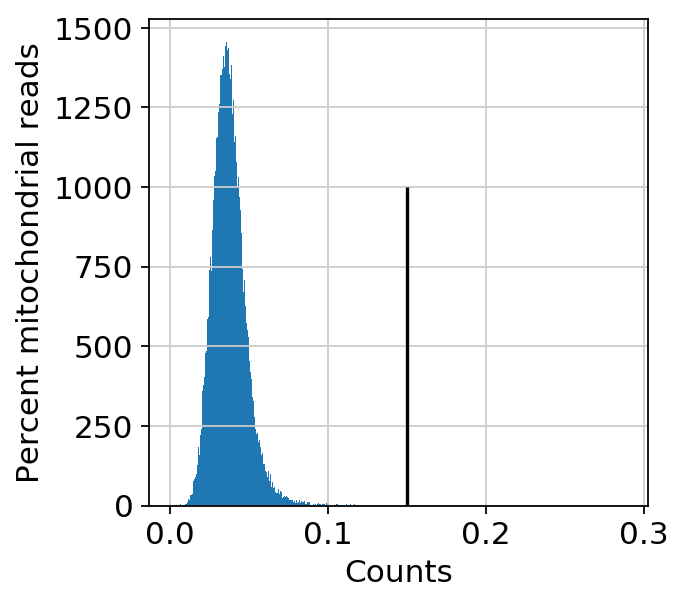

In [17]:
plt.hist(cell_adata.obs['percent_mito'].values,bins=500)
plt.vlines(0.15,0,1000);
plt.xlabel('Counts')
plt.ylabel('Percent mitochondrial reads');
# plt.xlim((0,0.1));

Only keep cells with low `percent_mito`.

In [18]:
cutoff = 0.15
cell_adata = cell_adata[cell_adata.obs['percent_mito'] < cutoff].copy()

In [19]:
cell_adata

AnnData object with n_obs × n_vars = 58769 × 33548 
    obs: 'DROPTYPE', 'IND', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'

Examine the number of genes expressed per cell.

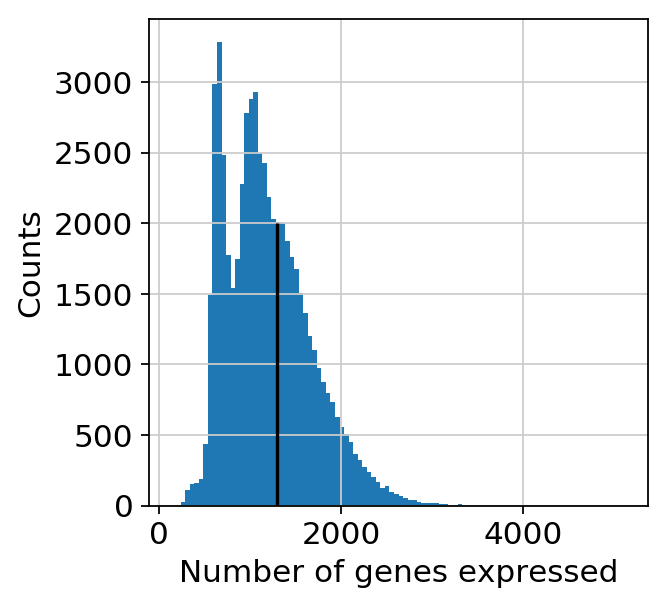

In [20]:
plt.hist(sc.pp.filter_cells(cell_adata, min_genes=0,inplace=False)[1],bins=100); # just to get out the number of genes expressed per cell
plt.ylabel('Counts')
plt.xlabel('Number of genes expressed');
plt.vlines(1300,0,2000);

I won't filter anything out here, but this may very well be a gauge for the doublets.

Standard processing here:

In [21]:
sc.pp.filter_genes(cell_adata,min_counts=1)

filtered out 9807 genes that are detected in less than 1 counts


In [22]:
adata.var.tail(10)

gene_ids     feature_types genome
CD4barcode1    Ab1CD4  Antibody Capture       
CD4barcode2    Ab2CD4  Antibody Capture       
CD4barcode3    Ab3CD4  Antibody Capture       
CD4barcode4    Ab4CD4  Antibody Capture       
CD4barcode5    Ab5CD4  Antibody Capture       
CD20barcode1  Ab1CD20  Antibody Capture       
CD20barcode2  Ab2CD20  Antibody Capture       
CD20barcode3  Ab3CD20  Antibody Capture       
CD20barcode4  Ab4CD20  Antibody Capture       
CD20barcode5  Ab5CD20  Antibody Capture

In [22]:
cell_adata

AnnData object with n_obs × n_vars = 58769 × 23741 
    obs: 'DROPTYPE', 'IND', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

# Merge pool  ADT counts¶

In [23]:
df_CD4h_1 = cell_adata[:,'CD4barcode1'].to_df()
df_CD4h_2 = cell_adata[:,'CD4barcode2'].to_df()
df_CD4h_3 = cell_adata[:,'CD4barcode3'].to_df()
df_CD4h_4 = cell_adata[:,'CD4barcode4'].to_df()
df_CD4h_5 = cell_adata[:,'CD4barcode5'].to_df()

df_CD20h_1 = cell_adata[:,'CD20barcode1'].to_df()
df_CD20h_2 = cell_adata[:,'CD20barcode2'].to_df()
df_CD20h_3 = cell_adata[:,'CD20barcode3'].to_df()
df_CD20h_4 = cell_adata[:,'CD20barcode4'].to_df()
df_CD20h_5 = cell_adata[:,'CD20barcode5'].to_df()

df_CD4h_merged = df_CD4h_1.join([df_CD4h_2,df_CD4h_3,df_CD4h_4,df_CD4h_5])
df_CD20h_merged = df_CD20h_1.join([df_CD20h_2,df_CD20h_3,df_CD20h_4,df_CD20h_5])

df_CD4h_merged['CD4_h_merged'] = df_CD4h_merged.sum(axis=1)
df_CD20h_merged['CD20_h_merged'] = df_CD20h_merged.sum(axis=1)

df_CD4_20_h_merged = df_CD4h_merged.join(df_CD20h_merged)
#type(cell_adata.obs['call'])
df_CD4_20_h_merged = df_CD4_20_h_merged.join(cell_adata.obs)

In [24]:
df_CD4_20_h_merged.head()

CD4barcode1  CD4barcode2  CD4barcode3  CD4barcode4  \
AAACCCAAGAGGGTGG-1        268.0         44.0          4.0         31.0   
AAACCCAAGAGTACCG-1          9.0         32.0          5.0         21.0   
AAACCCAAGATAGTCA-1         24.0         31.0          4.0         27.0   
AAACCCAAGCACTTTG-1        247.0         40.0         11.0         22.0   
AAACCCAAGCGCCTTG-1         18.0         48.0          4.0        253.0   

                    CD4barcode5  CD4_h_merged  CD20barcode1  CD20barcode2  \
AAACCCAAGAGGGTGG-1         35.0         382.0          65.0          58.0   
AAACCCAAGAGTACCG-1         20.0          87.0         300.0          55.0   
AAACCCAAGATAGTCA-1         22.0         108.0          63.0          54.0   
AAACCCAAGCACTTTG-1         34.0         354.0          63.0          82.0   
AAACCCAAGCGCCTTG-1         21.0         344.0          58.0          68.0   

                    CD20barcode3  CD20barcode4  CD20barcode5  CD20_h_merged  \
AAACCCAAGAGGGTGG-1           6.0          35.0          36.0          200.0   
AAACCCAAGAGTACCG-1           2.0          39.0          45.0          441.0   
AAACCCAAGATAGTCA-1           5.0         399.0          39.0          560.0   
AAACCCAAGCACTTTG-1          14.0          44.0          41.0          244.0   
AAACCCAAGCGCCTTG-1          10.0          49.0          38.0          223.0   

                   DROPTYPE     IND  percent_mito  
AAACCCAAGAGGGTGG-1      SNG  donor0      0.030961  
AAACCCAAGAGTACCG-1      SNG  donor1      0.053922  
AAACCCAAGATAGTCA-1      SNG  donor1      0.046521  
AAACCCAAGCACTTTG-1      SNG  donor0      0.022828  
AAACCCAAGCGCCTTG-1      SNG  donor0      0.032924

In [60]:
df_CD4_20_h_merged.shape

(58769, 15)

# Z-score norm or log1p + zscore

In [28]:
#df_call2 = df_CD4_20_h_merged['recall']
df_identity2 = df_CD4_20_h_merged['IND']

df_test_drop2 = df_CD4_20_h_merged.drop(['IND','DROPTYPE'],axis=1)

df_log1p=df_test_drop2.apply(np.log1p)

log_znorm_df=(df_log1p-df_log1p.mean())/df_log1p.std()

# log1p

In [24]:
df_log1p.head()

CD4barcode1  CD4barcode2  CD4_h_merged  CD20barcode1  \
AAACCCAAGAAGCGAA-1     5.529429     4.356709      5.796058      4.543295   
AAACCCAAGAATCTAG-1     3.332205     5.049856      5.209486      3.218876   
AAACCCAAGAGATGCC-1     5.257495     3.891820      5.480639      3.044523   
AAACCCAAGCCTAGGA-1     5.389072     4.663439      5.780744      4.290460   
AAACCCAAGCTGCCAC-1     3.713572     4.454347      4.836282      3.496508   

                    CD20barcode2  CD20_h_merged  percent_mito  
AAACCCAAGAAGCGAA-1      4.158883       5.056246      0.041481  
AAACCCAAGAATCTAG-1      3.663562       4.143135      0.027331  
AAACCCAAGAGATGCC-1      3.891820       4.234107      0.019216  
AAACCCAAGCCTAGGA-1      5.950643       6.122493      0.036673  
AAACCCAAGCTGCCAC-1      5.726848       5.826000      0.033638

# Gaussian mixture model test

In [29]:
!date
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')

Thu Jan 30 08:26:37 PST 2020


In [30]:
# Code is not currently simplified but quick and dirty here, still under optimization

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture

N=2
X1=df_log1p['CD4barcode1']
X2=df_log1p['CD4barcode2']
X3=df_log1p['CD4barcode3']
X4=df_log1p['CD4barcode4']
X5=df_log1p['CD4barcode5']
X6=df_log1p['CD20barcode1']
X7=df_log1p['CD20barcode2']
X8=df_log1p['CD20barcode3']
X9=df_log1p['CD20barcode4']
X10=df_log1p['CD20barcode5']
X11=df_log1p['CD4_h_merged']
X12=df_log1p['CD20_h_merged']

X1_1= X1.to_frame()
X2_1= X2.to_frame()
X3_1= X3.to_frame()
X4_1= X4.to_frame()
X5_1= X5.to_frame()
X6_1= X6.to_frame()
X7_1= X7.to_frame()
X8_1= X8.to_frame()
X9_1= X9.to_frame()
X10_1= X10.to_frame()
X11_1= X11.to_frame()
X12_1= X12.to_frame()

g1 = GaussianMixture(n_components=2).fit(X1_1)
g2 = GaussianMixture(n_components=2).fit(X2_1)
g3 = GaussianMixture(n_components=2).fit(X3_1)
g4 = GaussianMixture(n_components=2).fit(X4_1)
g5 = GaussianMixture(n_components=2).fit(X5_1)
g6 = GaussianMixture(n_components=2).fit(X6_1)
g7 = GaussianMixture(n_components=2).fit(X7_1)
g8 = GaussianMixture(n_components=2).fit(X8_1)
g9 = GaussianMixture(n_components=2).fit(X9_1)
g10 = GaussianMixture(n_components=2).fit(X10_1)
g11 = GaussianMixture(n_components=2).fit(X11_1)
g12 = GaussianMixture(n_components=2).fit(X12_1)

#g.predict_proba(X2)
#g.fit_predict(X2)
m1 = g1.means_
m2 = g2.means_
m3 = g3.means_
m4 = g4.means_
m5 = g5.means_
m6 = g6.means_
m7 = g7.means_
m8 = g8.means_
m9 = g9.means_
m10 = g10.means_
m11 = g11.means_
m12 = g12.means_

cov1 = g1.covariances_
cov2 = g2.covariances_
cov3 = g3.covariances_
cov4 = g4.covariances_
cov5 = g5.covariances_
cov6 = g6.covariances_
cov7 = g7.covariances_
cov8 = g8.covariances_
cov9 = g9.covariances_
cov10 = g10.covariances_
cov11 = g11.covariances_
cov12 = g12.covariances_

sigmas1 = [np.sqrt(np.trace(cov1[i])/N) for i in range(0,N) ]
sigmas2 = [np.sqrt(np.trace(cov2[i])/N) for i in range(0,N) ]
sigmas3 = [np.sqrt(np.trace(cov3[i])/N) for i in range(0,N) ]
sigmas4 = [np.sqrt(np.trace(cov4[i])/N) for i in range(0,N) ]
sigmas5 = [np.sqrt(np.trace(cov5[i])/N) for i in range(0,N) ]
sigmas6 = [np.sqrt(np.trace(cov6[i])/N) for i in range(0,N) ]
sigmas7 = [np.sqrt(np.trace(cov7[i])/N) for i in range(0,N) ]
sigmas8 = [np.sqrt(np.trace(cov8[i])/N) for i in range(0,N) ]
sigmas9 = [np.sqrt(np.trace(cov9[i])/N) for i in range(0,N) ]
sigmas10 = [np.sqrt(np.trace(cov10[i])/N) for i in range(0,N) ]
sigmas11 = [np.sqrt(np.trace(cov11[i])/N) for i in range(0,N) ]
sigmas12 = [np.sqrt(np.trace(cov12[i])/N) for i in range(0,N) ]

sigma_fin_1=np.mean(sigmas1)
sigma_fin_2=np.mean(sigmas2)
sigma_fin_3=np.mean(sigmas3)
sigma_fin_4=np.mean(sigmas4)
sigma_fin_5=np.mean(sigmas5)
sigma_fin_6=np.mean(sigmas6)
sigma_fin_7=np.mean(sigmas7)
sigma_fin_8=np.mean(sigmas8)
sigma_fin_9=np.mean(sigmas9)
sigma_fin_10=np.mean(sigmas10)
sigma_fin_11=np.mean(sigmas11)
sigma_fin_12=np.mean(sigmas12)

mean_fin_1 = np.mean(m1)
mean_fin_2 = np.mean(m2)
mean_fin_3 = np.mean(m3)
mean_fin_4 = np.mean(m4)
mean_fin_5 = np.mean(m5)
mean_fin_6 = np.mean(m6)
mean_fin_7 = np.mean(m7)
mean_fin_8 = np.mean(m8)
mean_fin_9 = np.mean(m9)
mean_fin_10 = np.mean(m10)
mean_fin_11 = np.mean(m11)
mean_fin_12 = np.mean(m12)


CD4_barcode1_norm = (df_log1p['CD4barcode1'] - mean_fin_1) /  sigma_fin_1
CD4_barcode2_norm = (df_log1p['CD4barcode2'] - mean_fin_2) /  sigma_fin_2
CD4_barcode3_norm = (df_log1p['CD4barcode3'] - mean_fin_3) /  sigma_fin_3
CD4_barcode4_norm = (df_log1p['CD4barcode4'] - mean_fin_4) /  sigma_fin_4
CD4_barcode5_norm = (df_log1p['CD4barcode5'] - mean_fin_5) /  sigma_fin_5

CD20_barcode1_norm = (df_log1p['CD20barcode1'] - mean_fin_6) /  sigma_fin_6
CD20_barcode2_norm = (df_log1p['CD20barcode2'] - mean_fin_7) /  sigma_fin_7
CD20_barcode3_norm = (df_log1p['CD20barcode3'] - mean_fin_8) /  sigma_fin_8
CD20_barcode4_norm = (df_log1p['CD20barcode4'] - mean_fin_9) /  sigma_fin_9
CD20_barcode5_norm = (df_log1p['CD20barcode5'] - mean_fin_10) /  sigma_fin_10

CD4_barcode_m_norm = (df_log1p['CD4_h_merged'] - mean_fin_11) /  sigma_fin_11
CD20_barcode_m_norm = (df_log1p['CD20_h_merged'] - mean_fin_12) /  sigma_fin_12

a = CD4_barcode1_norm.to_frame()
b = CD4_barcode2_norm.to_frame()
c = CD4_barcode3_norm.to_frame()
d = CD4_barcode4_norm.to_frame()
e = CD4_barcode5_norm.to_frame()

f = CD20_barcode1_norm.to_frame()
g = CD20_barcode2_norm.to_frame()
h = CD20_barcode3_norm.to_frame()
i = CD20_barcode4_norm.to_frame()
j = CD20_barcode5_norm.to_frame()

k = CD4_barcode_m_norm.to_frame()
l = CD20_barcode_m_norm.to_frame()

total = a.join([b,c,d, e, f,g,h,i,j,k,l])

gmm_df = total.join(df_identity2)
gmm_df.head()


CD4barcode1  CD4barcode2  CD4barcode3  CD4barcode4  \
AAACCCAAGAGGGTGG-1     4.733284    -3.277682    -5.795436    -4.133350   
AAACCCAAGAGTACCG-1    -7.412143    -4.377030    -5.219645    -5.564325   
AAACCCAAGATAGTCA-1    -4.031731    -4.486100    -5.795436    -4.643313   
AAACCCAAGCACTTTG-1     4.433414    -3.607642    -3.030609    -5.394561   
AAACCCAAGCGCCTTG-1    -5.044194    -2.975840    -5.795436     3.778203   

                    CD4barcode5  CD20barcode1  CD20barcode2  CD20barcode3  \
AAACCCAAGAGGGTGG-1    -3.223359     -2.632383     -3.192880     -3.689830   
AAACCCAAGAGTACCG-1    -5.268178      2.594677     -3.365332     -6.024014   
AAACCCAAGATAGTCA-1    -4.923054     -2.738380     -3.424875     -4.114493   
AAACCCAAGCACTTTG-1    -3.330232     -2.738380     -2.065020     -1.590242   
AAACCCAAGCGCCTTG-1    -5.091693     -3.018585     -2.675487     -2.444674   

                    CD20barcode4  CD20barcode5  CD4_h_merged  CD20_h_merged  \
AAACCCAAGAGGGTGG-1     -5.048341     -5.011944      0.841289      -2.591632   
AAACCCAAGAGTACCG-1     -4.677746     -4.203479     -3.483202      -0.028944   
AAACCCAAGATAGTCA-1      3.421363     -4.722452     -2.853916       0.746397   
AAACCCAAGCACTTTG-1     -4.263456     -4.541281      0.618061      -1.947863   
AAACCCAAGCGCCTTG-1     -3.892861     -4.816464      0.534042      -2.239294   

                       IND  
AAACCCAAGAGGGTGG-1  donor0  
AAACCCAAGAGTACCG-1  donor1  
AAACCCAAGATAGTCA-1  donor1  
AAACCCAAGCACTTTG-1  donor0  
AAACCCAAGCGCCTTG-1  donor0

In [26]:
# get the cell type data frame first from the UMAP information or can be manually added using arbitary expression cutoff 

#ctype_gmm_df = gmm_df.join(df_cell_type)
#ctype_gmm_df.head()

In [73]:
ctype_gmm_df = gmm_df.join(df_cell_type)

In [51]:
ctype_gmm_df.head()

CD4barcode1  CD4barcode2  CD4barcode3  CD4barcode4  \
AAACCCAAGAGGGTGG-1     4.733284    -3.277682    -5.795436    -4.133350   
AAACCCAAGAGTACCG-1    -7.412143    -4.377030    -5.219645    -5.564325   
AAACCCAAGATAGTCA-1    -4.031731    -4.486100    -5.795436    -4.643313   
AAACCCAAGCACTTTG-1     4.433414    -3.607642    -3.030609    -5.394561   
AAACCCAAGCGCCTTG-1    -5.044194    -2.975840    -5.795436     3.778203   

                    CD4barcode5  CD20barcode1  CD20barcode2  CD20barcode3  \
AAACCCAAGAGGGTGG-1    -3.223359     -2.632383     -3.192880     -3.689830   
AAACCCAAGAGTACCG-1    -5.268178      2.594677     -3.365332     -6.024014   
AAACCCAAGATAGTCA-1    -4.923054     -2.738380     -3.424875     -4.114493   
AAACCCAAGCACTTTG-1    -3.330232     -2.738380     -2.065020     -1.590242   
AAACCCAAGCGCCTTG-1    -5.091693     -3.018585     -2.675487     -2.444674   

                    CD20barcode4  CD20barcode5  CD4_h_merged  CD20_h_merged  \
AAACCCAAGAGGGTGG-1     -5.048341     -5.011944      0.794450      -2.594130   
AAACCCAAGAGTACCG-1     -4.677746     -4.203479     -3.489392      -0.032456   
AAACCCAAGATAGTCA-1      3.421363     -4.722452     -2.866021       0.742578   
AAACCCAAGCACTTTG-1     -4.263456     -4.541281      0.573320      -1.950616   
AAACCCAAGCGCCTTG-1     -3.892861     -4.816464      0.490091      -2.241931   

                       IND    cell_type  
AAACCCAAGAGGGTGG-1  donor0  CD4 T cells  
AAACCCAAGAGTACCG-1  donor1      B cells  
AAACCCAAGATAGTCA-1  donor1      B cells  
AAACCCAAGCACTTTG-1  donor0  CD4 T cells  
AAACCCAAGCGCCTTG-1  donor0  CD4 T cells

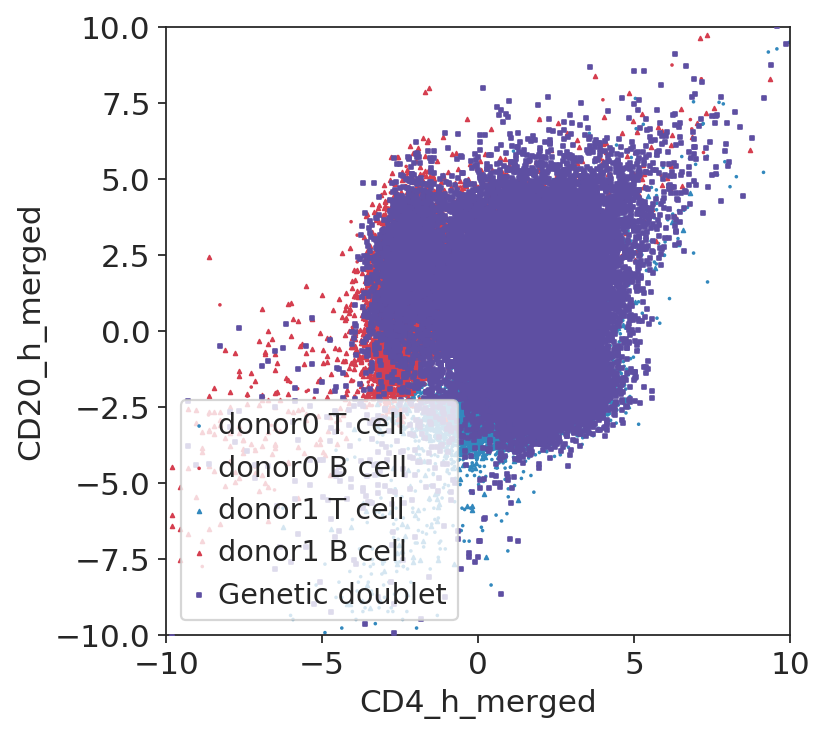

In [57]:
# plot before resolution

import pandas as pd
import seaborn as sns

plt.figure(figsize=(5,5))

sns.set_style("ticks")
a=ctype_gmm_df[(ctype_gmm_df['IND']=='donor0')&(ctype_gmm_df['cell_type']=='CD4 T cells')]
b=ctype_gmm_df[(ctype_gmm_df['IND']=='donor0')&(ctype_gmm_df['cell_type']=='B cells')]
c=ctype_gmm_df[(ctype_gmm_df['IND']=='donor1')&(ctype_gmm_df['cell_type']=='CD4 T cells')]
d=ctype_gmm_df[(ctype_gmm_df['IND']=='donor1')&(ctype_gmm_df['cell_type']=='B cells')]
e = ctype_gmm_df[ctype_gmm_df['IND']=='donor0,donor1']


s=sns.scatterplot(x="CD4_h_merged", y="CD20_h_merged", data=a, s=3, marker='.', facecolors='None', edgecolor='#3288BD', zorder=1, label="donor0 T cell")
s=sns.scatterplot(x="CD4_h_merged", y="CD20_h_merged", data=b, s=3, marker='.', facecolors='None', edgecolor='#D53E4F', zorder=2, label="donor0 B cell")
s=sns.scatterplot(x="CD4_h_merged", y="CD20_h_merged", data=c, s=3, marker='^', edgecolor=None, color='#3288BD', zorder=3, label="donor1 T cell")
s=sns.scatterplot(x="CD4_h_merged", y="CD20_h_merged", data=d, s=3, marker='^', edgecolor=None, color='#D53E4F', zorder=4, label="donor1 B cell")
s=sns.scatterplot(x="CD4_h_merged", y="CD20_h_merged", data=e, s=3, marker=',', edgecolor=None, color='#5E4FA2', zorder=5, label="Genetic doublet")

plt.xlim(-10,10)
plt.ylim(-10,10)

f = s.get_figure()
f.savefig("200204_v1.1_200K_TB_h_merged_donor_group_plot.png")

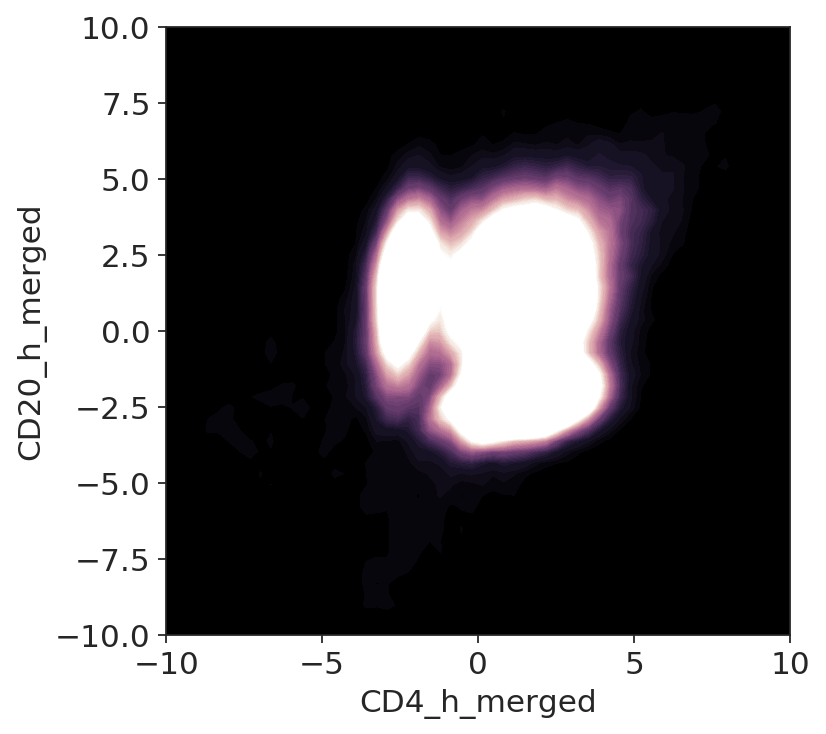

In [59]:
# density plot

f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=7, reverse=True)
g=sns.kdeplot(ctype_gmm_df.CD4_h_merged, ctype_gmm_df.CD20_h_merged, cmap=cmap, n_levels=300, shade=True);
plt.autoscale(True)
g.set(ylim=(-10,10))
g.set(xlim=(-10,10))
g.grid(False)

f = g.get_figure()
f.savefig("200204_v1.1_200K_TB_h_unresolved_density_plot.png")

# resolution plots

In [3]:
# # processed from the R code (mouse_human_analysis.R)
df_submission = pd.read_table("20200307_200k_total_ab_log_norm.tab", sep="\t")
df_fin = df_submission[(df_submission['manual1d.cell_type']=='1')|(df_submission['manual1d.cell_type']=='2')|(df_submission['manual1d.cell_type']=='1_2')]
df_fin.shape

(116827, 14)

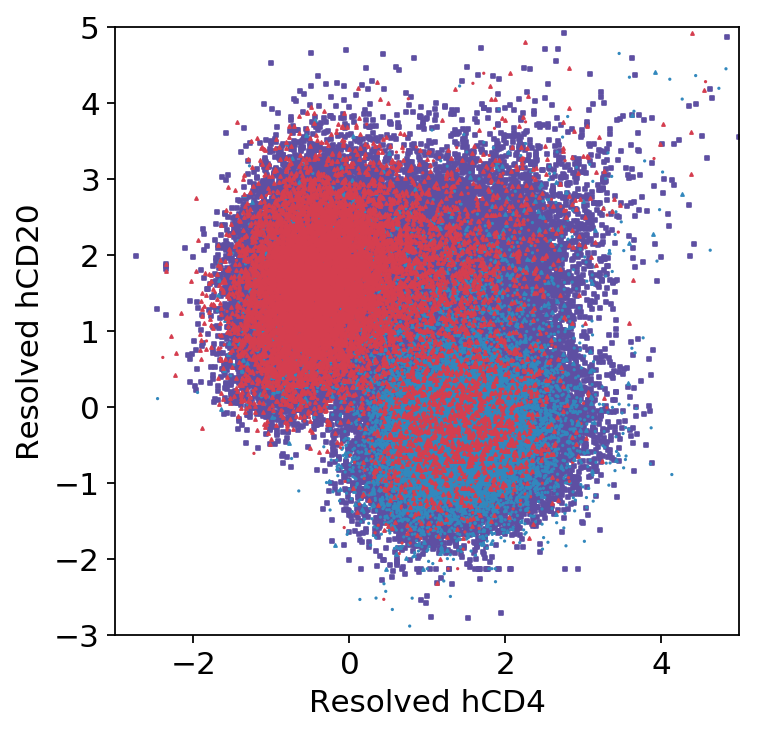

In [32]:
import pandas as pd
import seaborn as sns

plt.figure(figsize=(5,5))

a=df_fin[(df_fin['tx_type']=='t')&(df_fin['demux_droplet_type']=='donor0') ]
b=df_fin[(df_fin['tx_type']=='b')&(df_fin['demux_droplet_type']=='donor0')]
c=df_fin[(df_fin['tx_type']=='t')&(df_fin['demux_droplet_type']=='donor1') ]
d=df_fin[(df_fin['tx_type']=='b')&(df_fin['demux_droplet_type']=='donor1')]
e=df_fin[(df_fin['demux_droplet_type']=='doublet')]
#d=df_submission[(df_submission['jimmie']!='0_0') & (df_submission['ab_droplet_type']=='unstained')]

s=sns.scatterplot(x="ct1", y="ct2", data=a, s=2, marker='.', facecolors='None', edgecolor='#3288BD', zorder=2)
s=sns.scatterplot(x="ct1", y="ct2", data=b, s=2, marker='.', facecolors='None', edgecolor='#D53E4F', zorder=3 )
s=sns.scatterplot(x="ct1", y="ct2", data=c, s=2, marker='^', edgecolor=None, color='#3288BD', zorder=4 )
s=sns.scatterplot(x="ct1", y="ct2", data=d, s=2, marker='^', edgecolor=None, color='#D53E4F', zorder=5)
s=sns.scatterplot(x="ct1", y="ct2", data=e, s=2, marker=',', edgecolor=None, color='#5E4FA2', zorder=1)
#s=sns.scatterplot(x="ct1", y="ct2", data=d, s=3, marker='.', edgecolor=None, color='gray', zorder=4, label='negatives')

plt.xlabel("Resolved hCD4")
plt.ylabel("Resolved hCD20")

#plt.xlim(-2.5)
#plt.ylim(-2.5)
plt.ylim(-3,5)
plt.xlim(-3,5)

s.grid(False)

f = s.get_figure()
f.savefig("200204_v1.1_200K_TB_resolved_clean_tx_group_plot_final.png")

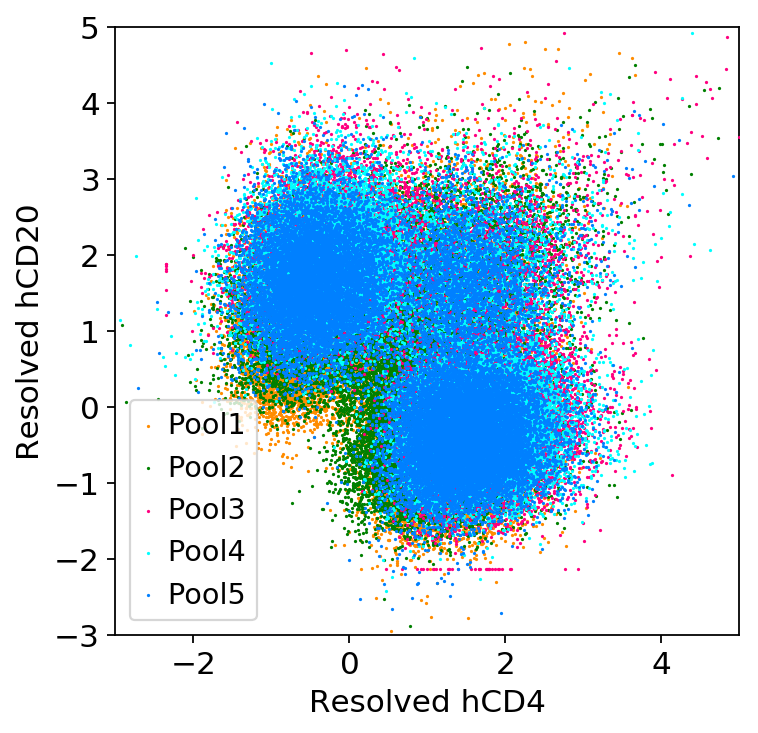

In [4]:
import seaborn as sns

plt.figure(figsize=(5,5))
a=df_fin[df_fin['batch']=='batch1']
b=df_fin[df_fin['batch']=='batch2']
c=df_fin[df_fin['batch']=='batch3']
d=df_fin[df_fin['batch']=='batch4']
e=df_fin[df_fin['batch']=='batch5']
#f=df_fin_resolved[df_fin_resolved['negatives']=='Negative']

s=sns.scatterplot(x="ct1", y="ct2", data=a, s=2, marker='.', edgecolor=None, color='darkorange', zorder=1, label="Pool1")
s=sns.scatterplot(x="ct1", y="ct2", data=b, s=2, marker='.', edgecolor=None, color='green', zorder=2, label="Pool2")
s=sns.scatterplot(x="ct1", y="ct2", data=c, s=2, marker='.', edgecolor=None, color='#FF0080', zorder=3, label="Pool3")
s=sns.scatterplot(x="ct1", y="ct2", data=d, s=2, marker='.', edgecolor=None, color='#00FFFF', zorder=4, label="Pool4")
s=sns.scatterplot(x="ct1", y="ct2", data=e, s=2, marker='.', edgecolor=None, color='#0080FF', zorder=4, label="Pool5")
#s=sns.scatterplot(x="CD4h_resolved", y="CD20h_resolved", data=b, s=10, marker='^', edgecolor='#D53E4F', facecolors='None', zorder=1, label="donor1")
#s=sns.scatterplot(x="CD29h_resolved",  y="CD29m_resolved", data=f, s=10, marker='.', edgecolor=None, color='grey', zorder=5, label="Negative")

plt.xlabel("Resolved hCD4")
plt.ylabel("Resolved hCD20")

plt.ylim(-3,5)
plt.xlim(-3,5)

s.grid(False)

f = s.get_figure()
f.savefig("200204_v1.1_200K_TB_resolved_batch_group_plot_final.png")

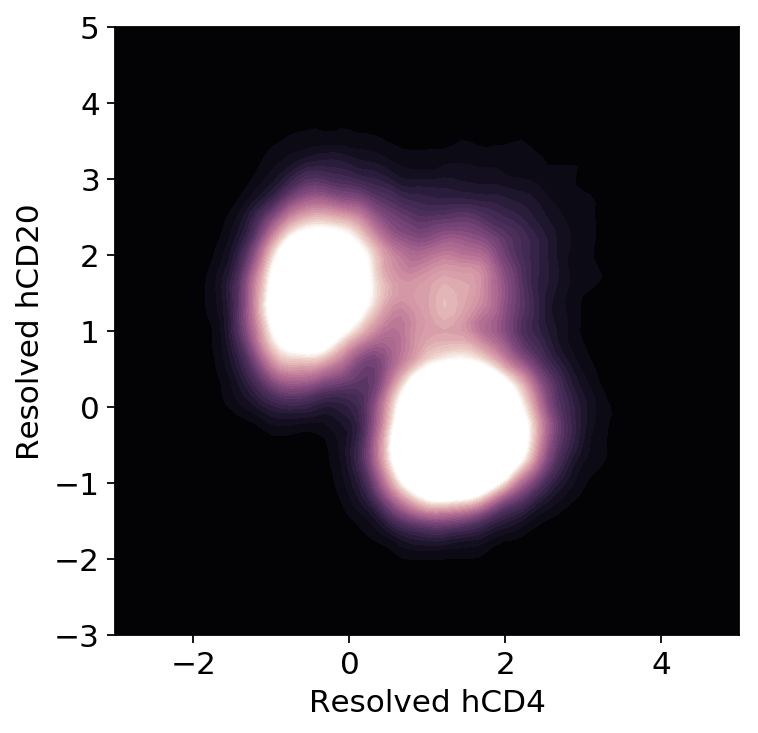

In [40]:
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=3, reverse=True)


g=sns.kdeplot(df_fin.ct1, df_fin.ct2, cmap=cmap, n_levels=100, shade=True);
plt.autoscale(True)
g.set(xlim=(-3,5))
g.set(ylim=(-3,5))
g.set(xlabel='Resolved hCD4')
g.set(ylabel='Resolved hCD20')
g.grid(False)

f = g.get_figure()
f.savefig("200204_v1.1_200K_TB_resolved_density_plot_final.png")

# UMAP for finding the cell type info

In [25]:
cell_adata.var

gene_ids     feature_types  genome   n_counts
AL627309.1    ENSG00000238009   Gene Expression  GRCh38       63.0
AL627309.3    ENSG00000239945   Gene Expression  GRCh38        3.0
AL627309.4    ENSG00000241599   Gene Expression  GRCh38        3.0
AL669831.2    ENSG00000229905   Gene Expression  GRCh38        7.0
AL669831.5    ENSG00000237491   Gene Expression  GRCh38     3624.0
...                       ...               ...     ...        ...
CD20barcode1          Ab1CD20  Antibody Capture          8812798.0
CD20barcode2          Ab2CD20  Antibody Capture          9401394.0
CD20barcode3          Ab3CD20  Antibody Capture          1353306.0
CD20barcode4          Ab4CD20  Antibody Capture          8269768.0
CD20barcode5          Ab5CD20  Antibody Capture          8307703.0

[23741 rows x 4 columns]

In [26]:
cell_adata2 = cell_adata[:,cell_adata.var.index[:-10]]

In [27]:
cell_adata2.var

gene_ids    feature_types  genome  n_counts
AL627309.1  ENSG00000238009  Gene Expression  GRCh38      63.0
AL627309.3  ENSG00000239945  Gene Expression  GRCh38       3.0
AL627309.4  ENSG00000241599  Gene Expression  GRCh38       3.0
AL669831.2  ENSG00000229905  Gene Expression  GRCh38       7.0
AL669831.5  ENSG00000237491  Gene Expression  GRCh38    3624.0
...                     ...              ...     ...       ...
AL354822.1  ENSG00000278384  Gene Expression  GRCh38     258.0
AC004556.1  ENSG00000276345  Gene Expression  GRCh38    1773.0
AC233755.2  ENSG00000277856  Gene Expression  GRCh38      59.0
AC233755.1  ENSG00000275063  Gene Expression  GRCh38     124.0
AC240274.1  ENSG00000271254  Gene Expression  GRCh38     590.0

[23731 rows x 4 columns]

In [28]:
sc.pp.normalize_per_cell(cell_adata2, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [29]:
sc.pp.log1p(cell_adata2)

Extract out highly variable genes, but don't subset just yet.

In [30]:
hv_out = sc.pp.highly_variable_genes(cell_adata2, inplace=False)

extracting highly variable genes
    Gene indices [12570] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:02)


In [31]:
cell_adata2.var.tail(10)

gene_ids    feature_types  genome  n_counts
AC145212.1  ENSG00000277400  Gene Expression  GRCh38       8.0
MAFIP       ENSG00000274847  Gene Expression  GRCh38     218.0
AC011043.1  ENSG00000276256  Gene Expression  GRCh38      25.0
AL592183.1  ENSG00000273748  Gene Expression  GRCh38    3210.0
AC007325.4  ENSG00000278817  Gene Expression  GRCh38      72.0
AL354822.1  ENSG00000278384  Gene Expression  GRCh38     258.0
AC004556.1  ENSG00000276345  Gene Expression  GRCh38    1773.0
AC233755.2  ENSG00000277856  Gene Expression  GRCh38      59.0
AC233755.1  ENSG00000275063  Gene Expression  GRCh38     124.0
AC240274.1  ENSG00000271254  Gene Expression  GRCh38     590.0

In [32]:
keep_genes = cell_adata2.var_names[hv_out['highly_variable']].tolist()
#proteins = ['CD4barcode1', 'CD4barcode2', 'CD20barcode1', 'CD20barcode2']
# proteins = ['CD4-BC1', 'CD4-BC2', 'CD14-BC1', 'CD14-BC2']

Are our proteins highly variable?

In [35]:
#[i in keep_genes for i in proteins]

Regress out unwanted variation.

In [33]:
cell_adata2 = cell_adata2[:,keep_genes].copy()

In [ ]:
#sc.pp.regress_out(cell_adata,['percent_mito','n_counts'],n_jobs=40)

regressing out ['percent_mito', 'n_counts']
    sparse input is densified and may lead to high memory use


... storing 'DROPTYPE' as categorical
... storing 'IND' as categorical
... storing 'gene_ids' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [34]:
sc.pp.scale(cell_adata2, max_value=10)

    ... scale_data: as `zero_center=True`, sparse input is densified and may lead to large memory consumption.
    ... clipping at max_value 10


Cluster on just the mRNA and then we'll add our protein markers back later.

In [35]:
cell_adata_mrnahv = cell_adata2[:,keep_genes].copy()
#cell_adata_p = cell_adata[:,proteins].copy()

Begin clustering and dimensionality reduction.

In [36]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(cell_adata_mrnahv,n_neighbors=10) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:14)
    computed neighbors (0:00:33)
    computed connectivities (0:00:03)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:37)


In [37]:
# resolution to 0.2 for small number of clusters 
sc.tl.leiden(cell_adata_mrnahv,resolution=0.2)

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:17)


In [38]:
sc.tl.umap(cell_adata_mrnahv)

computing UMAP
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:56)


... storing 'DROPTYPE' as categorical
... storing 'IND' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
/home/bhwang1/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:4204: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  (isinstance(c, collections.Iterable) and


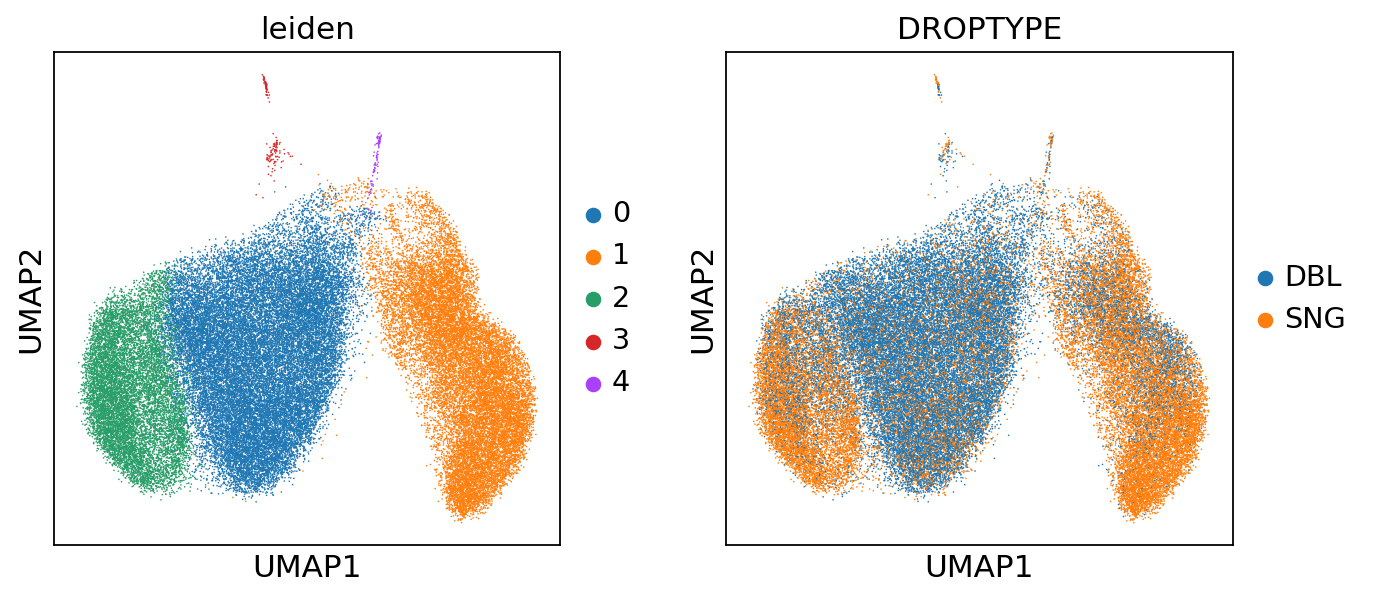

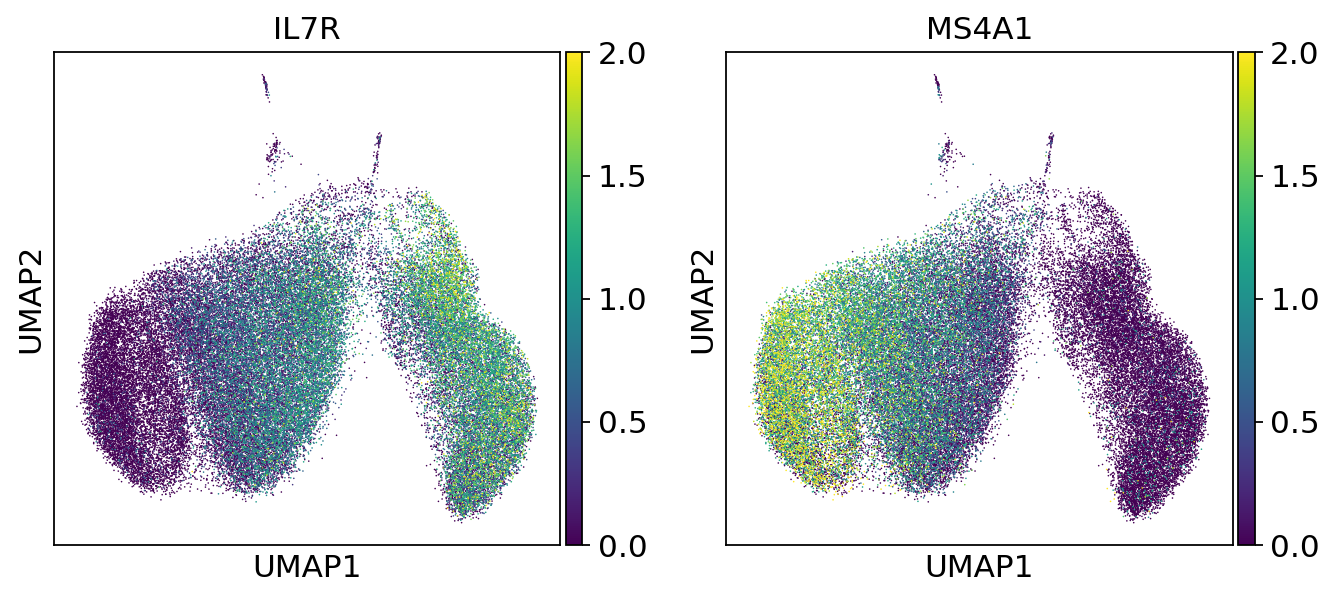

In [39]:
sc.pl.umap(cell_adata_mrnahv,color=['leiden','DROPTYPE'])
sc.pl.umap(cell_adata_mrnahv, color=['IL7R', 'MS4A1'], use_raw=False, vmin=0, vmax=2)
#sc.pl.umap(cell_adata, color=['leiden', 'IL7R', 'MS4A1'])

In [40]:
new_cluster_names = ['Doublets','CD4_T_cells','B_cells','x','y']
cell_adata_mrnahv.rename_categories('leiden', new_cluster_names)

old_to_new = dict(
  CD4_T_cells='CD4 T cells',
    B_cells='B cells',
    Doublets='Doublets',
     x='Doublets',
     y='Doublets'
)

cell_adata_mrnahv.obs['cell_type'] = (
    cell_adata_mrnahv.obs['leiden']
    .map(old_to_new)
    .astype('category')
)

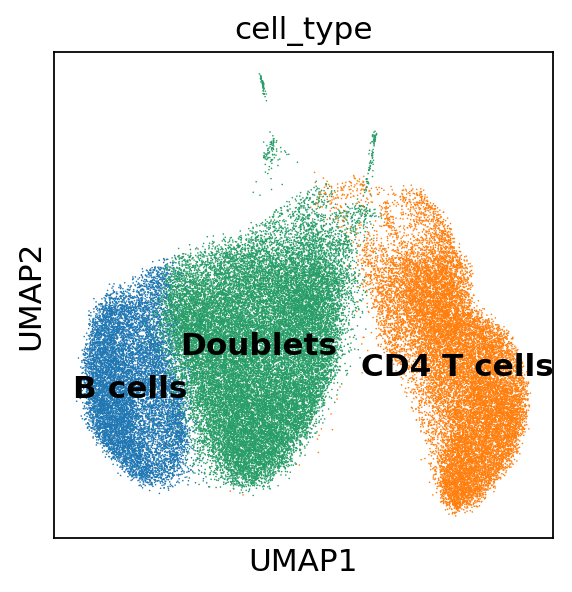

In [41]:
sc.pl.umap(cell_adata_mrnahv, color='cell_type', legend_loc='on data')

In [42]:
df_cell_type = cell_adata_mrnahv.obs['cell_type']

In [49]:
cell_adata_mrnahv

AnnData object with n_obs × n_vars = 58769 × 829 
    obs: 'DROPTYPE', 'IND', 'percent_mito', 'n_counts', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'log1p', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'DROPTYPE_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

Concatenate back the proteins with the mRNA.

In [78]:
#cell_adata_mrnahv.X = csr_matrix(cell_adata_mrnahv.X) # need this to concatenate
#cell_adata_comb = cell_adata_mrnahv.T.concatenate(cell_adata_p.T).T.copy()# concatenate along the variables axis

In [43]:
ctype_gmm_df = gmm_df.join(df_cell_type)

In [44]:
a=ctype_gmm_df['CD4_h_merged'].to_frame()
b=ctype_gmm_df['CD20_h_merged'].to_frame()


pgmm = a.join([b])
#pgmm.columns=['CD4barcode1','CD4barcode2','CD20barcode1','CD20barcode2']
pgmm_adata = sc.AnnData(pgmm)

In [45]:
pgmm.head()

CD4_h_merged  CD20_h_merged
AAACCCAAGAGGGTGG-1      0.794450      -2.589368
AAACCCAAGAGTACCG-1     -3.489392      -0.025769
AAACCCAAGATAGTCA-1     -2.866021       0.749848
AAACCCAAGCACTTTG-1      0.573320      -1.945370
AAACCCAAGCGCCTTG-1      0.490091      -2.236904

# concatenate back the proteins with GMM normalized ADT counts

In [46]:
cell_adata_mrnahv.X = csr_matrix(cell_adata_mrnahv.X) 
cell_adata_comb = cell_adata_mrnahv.T.concatenate(pgmm_adata.T).T.copy()

Keep all the nice unstructured (uns) data and multi-D annotations of observations (obsm).

In [47]:
cell_adata_comb.uns = cell_adata_mrnahv.uns # copy over the umap and leiden data
cell_adata_comb.obsm = cell_adata_mrnahv.obsm # copy over the umap and leiden data

In [48]:
cell_adata_comb.obs.columns

Index(['DROPTYPE-0', 'IND-0', 'percent_mito-0', 'n_counts-0', 'leiden-0',
       'cell_type-0'],
      dtype='object')

Do some cleanup.

In [81]:
# cell_adata_comb.obs.drop(['DROPTYPE-1','IND-1'],axis=1,inplace=True) # clean up the obs
#cell_adata_comb.obs.columns = ['DROPTYPE-0','IND-0','percent_mito','n_counts','leiden-0','DROPTYPE-1', 'IND-1'] # clean up the obs

In [82]:
#cell_adata_comb.var_names = cell_adata_mrnahv.var_names.tolist() + cell_adata_p.var_names.tolist() # clean up those var names

Visualize!

... storing 'DROPTYPE-0' as categorical
... storing 'IND-0' as categorical
... storing 'leiden-0' as categorical
... storing 'cell_type-0' as categorical
... storing 'feature_types' as categorical
... storing 'gene_ids' as categorical
... storing 'genome' as categorical


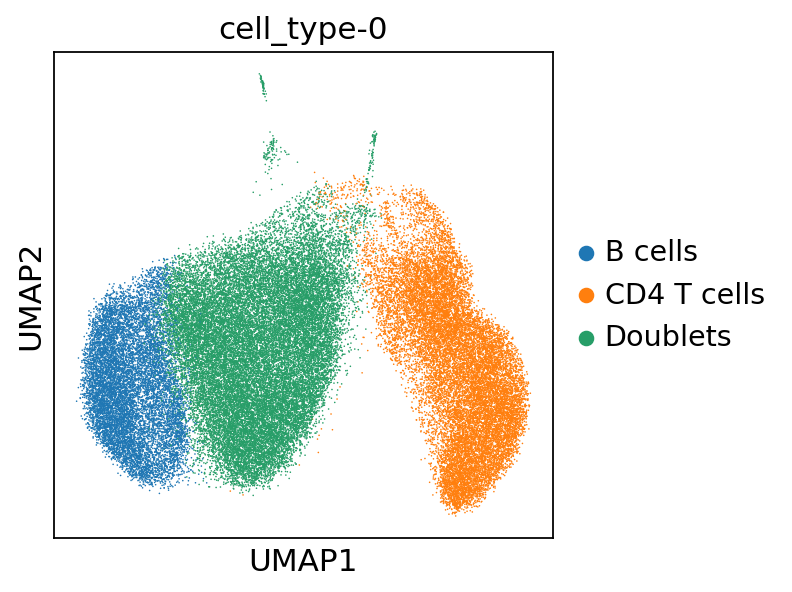

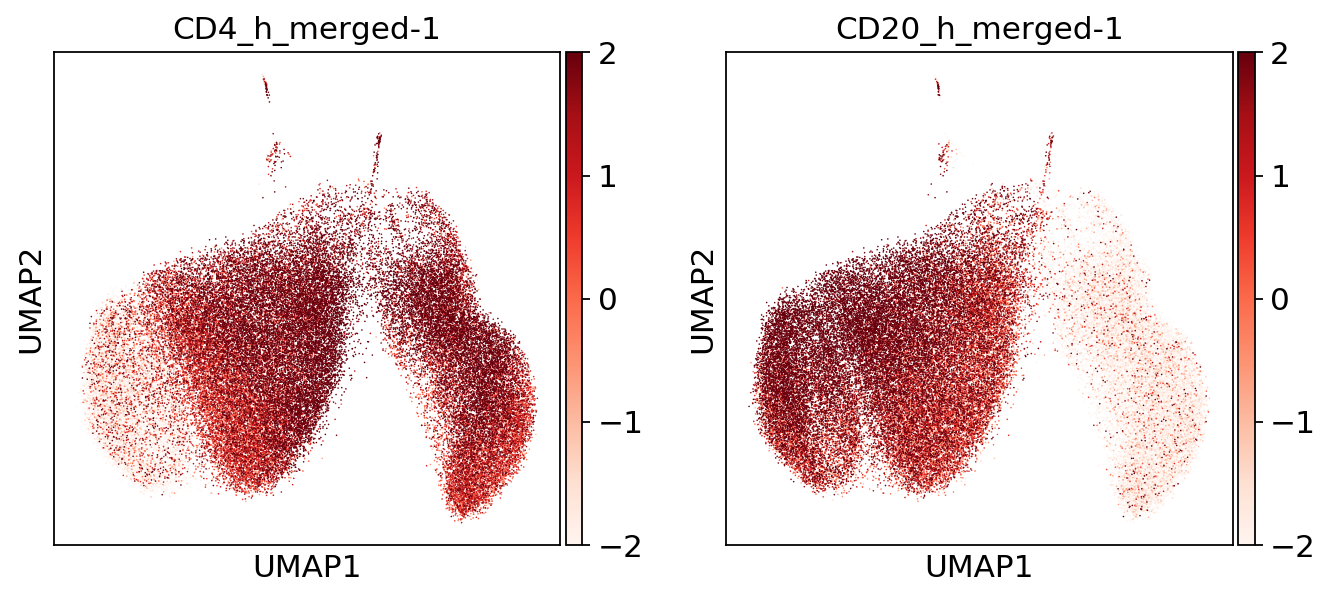

In [49]:
import matplotlib as mpl
sc.pl.umap(cell_adata_comb,color='cell_type-0', save="200204_high_h_umap_donor.png")
sc.pl.umap(cell_adata_comb,color=['CD4_h_merged-1','CD20_h_merged-1'], vmin=-2, vmax=2,palette="Set2", color_map=mpl.cm.Reds, save="200204_high_h_umap_merged_adt.png")
#sc.pl.umap(cell_adata_comb,color='DROPTYPE-0')
#sc.pl.umap(cell_adata_comb,color='percent_mito-0')
#sc.pl.umap(cell_adata_comb,color='n_counts-0')
#sc.pl.umap(cell_adata_comb,color='IND-0')